# Statistics about the dataset

* The purpose of this noteboook is to select sites for experiments.

## Imports

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from io_f import read_data_file
from pathlib import Path
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from collections import defaultdict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

from py_indoor_loc.utils import DataListingUtil
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.extract.wifi_fingerprint import extract_bssid_set
from py_indoor_loc.extract.wifi_fingerprint import create_fingerprint_vector

In [3]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString

In [4]:
%matplotlib inline

In [5]:
import networkx as nx

In [6]:
import seaborn as sns

In [9]:
from glob import glob

## Data Stats

In [7]:
data_dir = Path("../../data/train/")

In [13]:
sites = [os.path.basename(file) for file in glob(str(data_dir)  + "/*")]

In [15]:
len(sites)

204

In [18]:
def list_floors(site_id: str, data_dir: Path) -> list[str]:
  return [os.path.basename(file) for file in glob(str(data_dir / site_id)  + "/*")]

In [20]:
def list_track_files(site_id: str, floor_id: str, data_dir: Path) -> list[str]:
  return [file for file in glob(str(data_dir / site_id / floor_id) + "/*")]

In [21]:
site_id = sites[0]
site_floor_ids = list_floors(site_id, data_dir)

In [26]:
def extract_wifi_df(wifi: np.ndarray, time_shift_tol_ms: int = 2000, verbose=False) -> pd.DataFrame:
  """
  Wifi Fingerprint data extraction and cleaning.
  """
  wifi_schema = {
    "sys_ts": "system timestamp",
    "ssid": "the network name",
    "bssid": "the MAC address of the AP",
    "rssi": "RSSI",
    "freq": "Frequency",
    "last_seen_ts": "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)
  wifi_df = wifi_df[wifi_df["sys_ts"] - wifi_df["last_seen_ts"] <= time_shift_tol_ms].reset_index(drop=True)

  if verbose:
    print(f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}")
  
  return wifi_df

19

In [ ]:
def count_distinct_locations(waypoints: np.ndarray, bin_size: int = 2) -> int:
  bins = np.rint(waypoints / bin_size).astype(np.int32).tolist()
  bins = [tuple(e) for e in bins]
  return len(set(bins))

In [72]:
def count_wifi_beacons_and_locations(track_files: list[str], with_tqdm: bool = False):
  waypoint_list = []
  wifi_beacon_count = 0

  iterator = tqdm(track_files) if with_tqdm else track_files

  for track_file in iterator:
    path_datas = read_data_file(track_file)
    waypoint_list.append(path_datas.waypoint[:, 1:])

    if len(path_datas.wifi) == 0:
      continue
    
    wifi_df = extract_wifi_df(path_datas.wifi, time_shift_tol_ms=1000)
    wifi_beacon_count += wifi_df["sys_ts"].unique().shape[0]

  waypoints = np.vstack(waypoint_list)
  location_count = count_distinct_locations(waypoints, bin_size=2)

  return wifi_beacon_count, location_count

In [128]:
with open("../../data/output/site_floor_stats.csv", "w") as f:
  f.write("site_id,floor_id,wifi_beacon_count,location_count\n")
  f.flush()

  for site_id in tqdm(sites, desc="Site"):
    site_floor_ids = list_floors(site_id, data_dir)
    for floor_id in tqdm(site_floor_ids, desc="Floor"):
      track_files = list_track_files(site_id, floor_id, data_dir)
      wifi_beacon_count, location_count = count_wifi_beacons_and_locations(track_files)
      f.write(f"{site_id},{floor_id},{wifi_beacon_count},{location_count}\n")
      f.flush()
    

Site:   8%|▊         | 17/204 [05:22<29:52,  9.59s/it]

Failed to processing line: ['1559722249696', 'TYPE_ACCELEROMETER']. Caused by list index out of range


Site:  25%|██▌       | 51/204 [13:04<19:52,  7.79s/it]

Failed to processing line: ['1559699299331', 'TYPE_ROTATION_VECTOR', '0.17401376', '-0.0031055238']. Caused by list index out of range


Site: 100%|██████████| 204/204 [42:56<00:00, 12.63s/it]


In [129]:
floor_stats_df = pd.read_csv("../../data/output/site_floor_stats.csv")

In [131]:
floor_stats_df["site_id"] = floor_stats_df["site_id"].astype("category")
floor_stats_df["floor_id"] = floor_stats_df["floor_id"].astype("category")

In [134]:
floor_stats_df["sample_per_loc"] = floor_stats_df["wifi_beacon_count"] / floor_stats_df["location_count"]

In [148]:
floor_stats_df.sort_values("wifi_beacon_count", ascending=False, inplace=True)

In [153]:
floor_stats_df[(floor_stats_df["sample_per_loc"] >= 10)]

,site_id,floor_id,wifi_beacon_count,location_count,sample_per_loc
166,5cd56c18e2acfd2d33b6c321,B1,13322,376,35.430851
405,5cd56be3e2acfd2d33b66bae,F1,9126,314,29.063694
345,5d2709b303f801723c327472,1F,7117,267,26.655431
406,5cd56be3e2acfd2d33b66bae,F3,6959,241,28.875519
937,5cdac620e403deddaf467fc0,8F,6954,254,27.377953
...,...,...,...,...,...
19,5cd56b9de2acfd2d33b5fc50,F2,48,2,24.000000
369,5cd56b64e2acfd2d33b5932f,6F,41,2,20.500000
41,5cd56be5e2acfd2d33b66e3f,F3,38,3,12.666667
819,5cd56b90e2acfd2d33b5e33f,F5,27,2,13.500000


<Axes: >

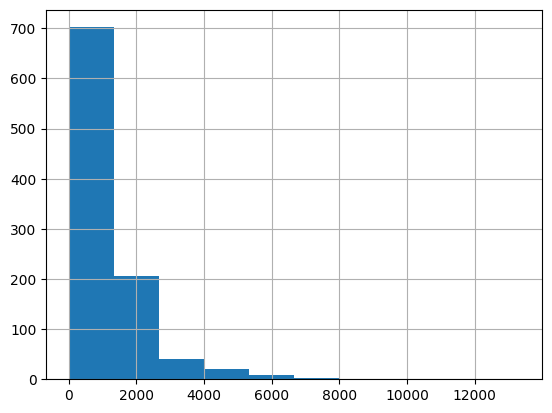

In [146]:
floor_stats_df["wifi_beacon_count"].hist()

In [139]:
floor_stats_df[floor_stats_df["sample_per_loc"] == floor_stats_df["sample_per_loc"].max()]

,site_id,floor_id,wifi_beacon_count,location_count,sample_per_loc
903,5cd56b5ae2acfd2d33b58546,F1,2076,31,66.967742


In [77]:
wifi_fingerprint_data_dir = Path("../../data/wifi_fingerprint_manual/train/")

In [ ]:
with open("../../data/output/site_floor_wifi_beacon_stats.csv", "w") as f:
  f.write("site_id,floor_id,wifi_beacon_count,location_count\n")
  f.flush()

  for site_id in tqdm(sites, desc="Site"):
    site_floor_ids = list_floors(site_id, data_dir)
    for floor_id in tqdm(site_floor_ids, desc="Floor"):
      track_files = list_track_files(site_id, floor_id, data_dir)
      wifi_beacon_count, location_count = count_wifi_beacons_and_locations(track_files)
      f.write(f"{site_id},{floor_id},{wifi_beacon_count},{location_count}\n")
      f.flush()
    

In [121]:
site_id = "5cd56c18e2acfd2d33b6c321"
floor_id = "L2"

In [122]:
train_files = glob(str(wifi_fingerprint_data_dir / site_id / floor_id) + "/*_wifi_fingerprint.csv")

In [123]:
wifi_fingerprint_df_list = [pd.read_csv(train_file) for train_file in train_files]

In [124]:
wifi_beacon_count = np.sum([df["sys_ts"].unique().shape[0] for df in wifi_fingerprint_df_list])

In [125]:
wifi_beacon_count

2515

In [126]:
location_count = count_distinct_locations(pd.concat(wifi_fingerprint_df_list)[["x", "y"]].values, bin_size=2)

In [127]:
location_count

737